In [1]:
# import dataset
from torchvision.datasets import MNIST

# import Conv.NN PyTorch packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

# import PyTorch data functions
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, ToPILImage
from torch.optim import Adam
from torch import nn

In [2]:
class LeNet(Module):
	def __init__(self, numChannels, classes):
		# call the parent constructor
		super(LeNet, self).__init__()
		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5, 5))
		self.relu1 = ReLU()
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize first (and only) set of FC => RELU layers
		self.fc1 = Linear(in_features=800, out_features=500)
		self.relu3 = ReLU()
		# initialize our softmax classifier
		self.fc2 = Linear(in_features=500, out_features=classes)
		self.logSoftmax = LogSoftmax(dim=1)

	def forward(self, x):
		# pass the input through our first set of layers
		# CONV => RELU => MAX POOL
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)
		# pass previous layer output through the second layer
		# CONV => RELU => MAX POOL 
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		# flatten the output from the previous layer and pass it
		# through FC => RELU layer
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		# pass the output to our softmax classifier to get predictions
		x = self.fc2(x)
		output = self.logSoftmax(x)
		# return output predictions
		return output

In [3]:
# import the necessary packages
import matplotlib
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
import time

In [5]:
# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# load the MNIST dataset
print("[INFO] loading the MNIST dataset...")
trainData = MNIST(root="data", train=True, download=True, transform=ToTensor())
testData = MNIST(root="data", train=False, download=True, transform=ToTensor())
# calculate the train/validation split
print("[INFO] generating the train/validation split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)
(trainData, valData) = random_split(trainData,
	[numTrainSamples, numValSamples],
	generator=torch.Generator().manual_seed(42))

[INFO] loading the MNIST dataset...


100%|██████████| 9912422/9912422 [00:00<00:00, 78629294.50it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 63025855.27it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 32445819.87it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12924375.01it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



[INFO] generating the train/validation split...


In [7]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [8]:
# initialize the LeNet model
print("[INFO] initializing the LeNet model...")
model = LeNet(
	numChannels=1,
	classes=len(trainData.dataset.classes)).to(device)
# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}
# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()

[INFO] initializing the LeNet model...
[INFO] training the network...


In [9]:
# loop over our epochs
for e in range(0, EPOCHS):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	valCorrect = 0
	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)
		# zero out the gradients, perform the backpropagation step,
		# and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()

    # switch off autograd for evaluation
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
		# loop over the validation set
		for (x, y) in valDataLoader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = model(x)
			totalValLoss += lossFn(pred, y)
			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(
				torch.float).sum().item()

	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	valCorrect = valCorrect / len(valDataLoader.dataset)
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_acc"].append(valCorrect)
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
		avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
		avgValLoss, valCorrect))

[INFO] EPOCH: 1/10
Train loss: 0.182650, Train accuracy: 0.9444
Val loss: 0.076560, Val accuracy: 0.9765

[INFO] EPOCH: 2/10
Train loss: 0.052182, Train accuracy: 0.9844
Val loss: 0.046006, Val accuracy: 0.9856

[INFO] EPOCH: 3/10
Train loss: 0.033868, Train accuracy: 0.9899
Val loss: 0.043173, Val accuracy: 0.9882

[INFO] EPOCH: 4/10
Train loss: 0.024252, Train accuracy: 0.9928
Val loss: 0.046329, Val accuracy: 0.9871

[INFO] EPOCH: 5/10
Train loss: 0.018392, Train accuracy: 0.9943
Val loss: 0.040716, Val accuracy: 0.9894

[INFO] EPOCH: 6/10
Train loss: 0.015237, Train accuracy: 0.9952
Val loss: 0.034953, Val accuracy: 0.9909

[INFO] EPOCH: 7/10
Train loss: 0.011971, Train accuracy: 0.9963
Val loss: 0.032607, Val accuracy: 0.9920

[INFO] EPOCH: 8/10
Train loss: 0.008975, Train accuracy: 0.9973
Val loss: 0.045170, Val accuracy: 0.9891

[INFO] EPOCH: 9/10
Train loss: 0.008888, Train accuracy: 0.9970
Val loss: 0.034472, Val accuracy: 0.9911

[INFO] EPOCH: 10/10
Train loss: 0.008464, Trai

In [10]:
# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))
# we can now evaluate the network on the test set
print("[INFO] evaluating network...")
# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()

	# initialize a list to store our predictions
	preds = []
	# loop over the test set
	for (x, y) in testDataLoader:
		# send the input to the device
		x = x.to(device)
		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
# generate a classification report
print(classification_report(testData.targets.cpu().numpy(),
	np.array(preds), target_names=testData.classes))

[INFO] total time taken to train the model: 495.09s
[INFO] evaluating network...
              precision    recall  f1-score   support

    0 - zero       0.99      1.00      1.00       980
     1 - one       0.99      1.00      1.00      1135
     2 - two       0.99      0.99      0.99      1032
   3 - three       0.99      0.99      0.99      1010
    4 - four       0.99      0.98      0.99       982
    5 - five       0.99      0.99      0.99       892
     6 - six       0.99      0.99      0.99       958
   7 - seven       0.99      0.99      0.99      1028
   8 - eight       0.99      0.99      0.99       974
    9 - nine       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



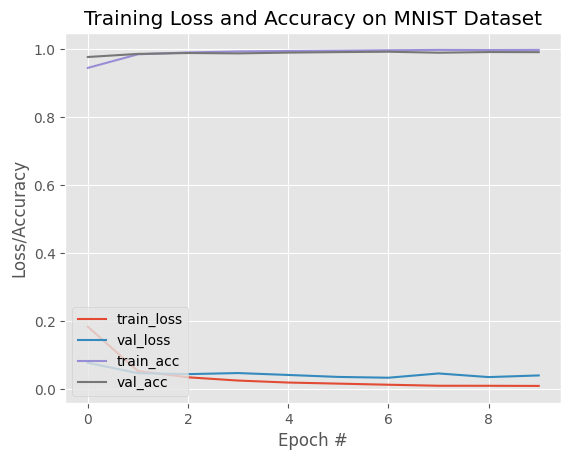

In [11]:
%matplotlib inline
# plot the training loss and accuracy
plt.style.use("ggplot")

plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on MNIST Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()